# Cálculo de Erro - Medidas StimSHIELD

Ref.:
- http://www.estatica-metrologia.com.br/erros.php
- https://www.wmo.int/pages/prog/gcos/documents/gruanmanuals/UK_NPL/mgpg11.pdf
- http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import fnmatch
import os

In [3]:
files = !ls ./frequencia/*.csv
df = pd.concat([pd.read_csv(f, skiprows=1, index_col=0) for f in files], axis=1, keys=files)
pd.to_datetime(df.index, unit='ms');
df.dropna(inplace=True)

In [4]:
df.describe().transpose()

count      mean  \
./frequencia/Frequência - Bateria1 - Onda1.csv Volt  49974.0 -0.472140   
./frequencia/Frequência - Bateria1 - Onda2.csv Volt  49974.0 -0.458006   
./frequencia/Frequência - Bateria1 - Onda3.csv Volt  49974.0 -0.453380   
./frequencia/Frequência - Bateria1 - Onda4.csv Volt  49974.0 -0.455270   
./frequencia/Frequência - Bateria2 - Onda1.csv Volt  49974.0 -0.453428   
./frequencia/Frequência - Bateria2 - Onda2.csv Volt  49974.0 -0.453439   
./frequencia/Frequência - Bateria2 - Onda3.csv Volt  49974.0 -0.452680   
./frequencia/Frequência - Bateria2 - Onda4.csv Volt  49974.0 -0.454067   
./frequencia/Frequência - Bateria3 - Onda1.csv Volt  49974.0 -0.452786   
./frequencia/Frequência - Bateria3 - Onda2.csv Volt  49974.0 -0.451767   
./frequencia/Frequência - Bateria3 - Onda3.csv Volt  49974.0 -0.436702   
./frequencia/Frequência - Bateria3 - Onda4.csv Volt  49974.0 -0.450414   

                                                          std        min  \
./frequencia/Frequência - Bateria1 - Onda1.csv Volt  4.372316 -31.758794   
./frequencia/Frequência - Bateria1 - Onda2.csv Volt  4.359785 -31.758794   
./frequencia/Frequência - Bateria1 - Onda3.csv Volt  4.390292 -35.075377   
./frequencia/Frequência - Bateria1 - Onda4.csv Volt  4.389545 -33.994975   
./frequencia/Frequência - Bateria2 - Onda1.csv Volt  4.371262 -31.733669   
./frequencia/Frequência - Bateria2 - Onda2.csv Volt  4.375616 -31.758794   
./frequencia/Frequência - Bateria2 - Onda3.csv Volt  4.370814 -31.758794   
./frequencia/Frequência - Bateria2 - Onda4.csv Volt  4.364428 -34.346734   
./frequencia/Frequência - Bateria3 - Onda1.csv Volt  4.372547 -31.758794   
./frequencia/Frequência - Bateria3 - Onda2.csv Volt  4.390673 -31.758794   
./frequencia/Frequência - Bateria3 - Onda3.csv Volt  4.389516 -31.758794   
./frequencia/Frequência - Bateria3 - Onda4.csv Volt  4.362097 -31.758794   

                                                          25%      50%  \
./frequencia/Frequência - Bateria1 - Onda1.csv Volt -0.502513 -0.40201   
./frequencia/Frequência - Bateria1 - Onda2.csv Volt -0.427136 -0.40201   
./frequencia/Frequência - Bateria1 - Onda3.csv Volt -0.402010 -0.40201   
./frequencia/Frequência - Bateria1 - Onda4.csv Volt -0.402010 -0.40201   
./frequencia/Frequência - Bateria2 - Onda1.csv Volt -0.402010 -0.40201   
./frequencia/Frequência - Bateria2 - Onda2.csv Volt -0.402010 -0.40201   
./frequencia/Frequência - Bateria2 - Onda3.csv Volt -0.402010 -0.40201   
./frequencia/Frequência - Bateria2 - Onda4.csv Volt -0.402010 -0.40201   
./frequencia/Frequência - Bateria3 - Onda1.csv Volt -0.402010 -0.40201   
./frequencia/Frequência - Bateria3 - Onda2.csv Volt -0.402010 -0.40201   
./frequencia/Frequência - Bateria3 - Onda3.csv Volt -0.402010 -0.40201   
./frequencia/Frequência - Bateria3 - Onda4.csv Volt -0.402010 -0.40201   

                                                         75%        max  
./frequencia/Frequência - Bateria1 - Onda1.csv Volt -0.40201  30.527638  
./frequencia/Frequência - Bateria1 - Onda2.csv Volt -0.40201  30.527638  
./frequencia/Frequência - Bateria1 - Onda3.csv Volt -0.40201  30.552764  
./frequencia/Frequência - Bateria1 - Onda4.csv Volt -0.40201  30.552764  
./frequencia/Frequência - Bateria2 - Onda1.csv Volt -0.40201  30.552764  
./frequencia/Frequência - Bateria2 - Onda2.csv Volt -0.40201  30.552764  
./frequencia/Frequência - Bateria2 - Onda3.csv Volt -0.40201  30.552764  
./frequencia/Frequência - Bateria2 - Onda4.csv Volt -0.40201  30.552764  
./frequencia/Frequência - Bateria3 - Onda1.csv Volt -0.40201  30.502513  
./frequencia/Frequência - Bateria3 - Onda2.csv Volt -0.40201  30.552764  
./frequencia/Frequência - Bateria3 - Onda3.csv Volt -0.40201  30.552764  
./frequencia/Frequência - Bateria3 - Onda4.csv Volt -0.40201  30.552764

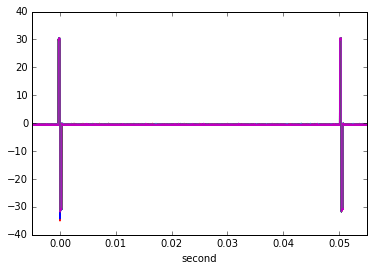

In [5]:
df.plot(legend=None)

In [6]:
from scipy.signal import find_peaks_cwt
from scipy.signal import savgol_filter

interval = {}
for i in df.columns.levels[0]:
    data = df[i]['Volt']
    # smooth the derivate curve o sinal and find peaks
    peakind = find_peaks_cwt(savgol_filter(data.diff(), 3 ,1), np.arange(0.9*data.max(),data.max()))
    _temp_ = data[data.index[peakind]][data[data.index[peakind]].values > 30]
    interval[i] = _temp_.index[_temp_.index > 0][:1] - _temp_.index[0]
#     print(interval[i])


In [7]:
df_freq = pd.DataFrame(interval)
df_freq = df_freq.transpose()
df_freq.columns = ['interval']
df_freq['frequency'] = 1/df_freq.interval
df_freq.describe()

interval  frequency
count  12.000000  12.000000
mean    0.050379  19.849948
std     0.000187   0.073517
min     0.050122  19.750043
25%     0.050315  19.824010
50%     0.050378  19.849777
75%     0.050444  19.874960
max     0.050633  19.951478

## Cálculo da Incerteza de Medição

### Equações

#### Desvio Padrão (S)

\begin{equation*}
S = {\sqrt{\sum(MM - M^2)} \over n-1}
\end{equation*}

Onde:  
s = Desvio Padrão;  
MM = Média das Medidas;  
M = Valores obtidos em cada leitura efetuada no sistema de medição;  
n = Número total de ensaios em cada ponto medido.  

### Cáculo da Incerteza tipo A (Ua)

\begin{equation*}
U_a = {S \over \sqrt{n}}
\end{equation*}

Onde:   
Ua = Incerteza de Medição tipo A;  
s = Desvio Padrão;  
n = Número total de ensaios em cada ponto medido.  

### Cálculo da Incerteza em função da resolução (Ures)

\begin{equation*}
U_{res} = {res \over 2}
\end{equation*}

Onde:  
Ures = Incerteza em função da resolução;   
res = Resolução em função da divisão de escala do instrumento;  

### Cálculo da Incerteza Combinada (Uc)

\begin{equation*}
U_{c} = \sqrt{U_{a}^{2} + U_{pad}^{2} + U_{res}^{2}}
\end{equation*}

Onde:  
Uc = Incerteza de Medição Combinada;  
Ua = Incerteza de Medição do tipo A;  
Upad = Incerteza de Medição do padrão utilizado;(\*\*)  
Ures = Incerteza de medição em função da resolução;   

(\*\*) A incerteza em função do padrão deve ser dividida por seu fator multiplicativo, conforme certificado.  
(Ex.: k=2, dividir a incerteza por 2/k=2,47, dividir a incerteza do padrão por 2,47).  
Se não houver declaração de incerteza expandida (fator k), dividir a incerteza por raiz de três.

### Cálculo da Incerteza Expandida (U95)

\begin{equation*}
U95 = k.U_{c}
\end{equation*}

Onde:   
Uc = Incerteza de Medição Combinada;   
k = Fator de abrangência para um nível de confiança aproximado de 95%, onde k@2;  
U95 = Incerteza de Medição Expandida com nível de confiança de 95%;  
Obs.: O fator k está diretamente relacionado com o grau de probabilidade de acerto do cálculo da incerteza. Para cada percentual existe um valor k definido. Este valor pode ter variações no seu valor em função do número de medidas realizadas e também das fontes de incerteza a serem consideradas.   
k = 1 ® Probabilidade = 68%;  
k = 2 ® Probabilidade = 95%;  
k = 3 ® Probabilidade = 99%;  

## Incerteza da Medição (pico a pico)

In [8]:
print('Média de todas as medições:', df_freq.frequency.mean())

Ua = df_freq.frequency.std()/np.sqrt(df_freq.frequency.count())
print("Ua =", Ua)

res = 0.000001 # extraído da medida, valor minimo capaz de ser adquirido pelo equipamento
Ures = res/2
print("Ures =", Ures)

Upad = ((df_freq.frequency.max() - df_freq.frequency.min())/2)/np.sqrt(3)
Uc = np.sqrt(Ua**2 + Upad**2 + Ures**2)
print("Upad =", Upad)
print("Uc =", Uc)

k = 1/np.sqrt(3)
U95 = k*Uc
print("U95 =", U95)

Média de todas as medições: 19.8499476633
Ua = 0.0212224941053
Ures = 5e-07
Upad = 0.0581491473907
Uc = 0.0619008691261
U95 = 0.035738483453
